In [3]:
%matplotlib inline

import pickle
import itertools
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, lil_matrix, vstack
from sklearn.metrics.pairwise import rbf_kernel, linear_kernel
from tqdm import tqdm
from pympler import asizeof

In [4]:
plt.rc("font", family="DejaVu Sans")
sns.set(font_scale=2)

In [5]:
%%time

data = pickle.load(open("../data/parsed/LSHTC1_train.dump", "rb"))
labels = pickle.load(open("../data/parsed/LSHTC1_train_out.dump", "rb"))

CPU times: user 61.8 ms, sys: 187 ms, total: 249 ms
Wall time: 337 ms


In [36]:
data = vstack([data[labels == 1630], data[labels == 2404]])

In [264]:
data = data[:1000, :]

In [6]:
data

<126871x409774 sparse matrix of type '<class 'numpy.int32'>'
	with 21900733 stored elements in Compressed Sparse Row format>

---

In [ ]:
%timeit (data[10, :] * dataT[:, 20])[0, 0]

In [ ]:
%timeit data[10, :].dot(dataT[:, 20])[0, 0]

In [ ]:
%timeit data[10].multiply(data[20]).sum()

---

In [7]:
# n, d = data.shape

# kernel = lambda i, j: rbf_kernel(data[i:i+1, :], data[j:j+1, :], gamma=1/100)[0, 0] # rbf kernel
# kernel = lambda i, j: (data[i, :] * dataT[:, j])[0, 0] # linear kernel

# km_gold = rbf_kernel(data, gamma=1/100)
# km_gold = linear_kernel(data)
# norm = km_gold.sum()
# best = km_gold.max()

In [8]:
# km_gold[km_gold > 12500] = 12500

In [9]:
def bernstein_sparsification(X, e, random_seed=None, n_iter=None, debug_every=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    scores = ([], [])
    X_1st_norm = X.sum()
    is_positive = X.min() >= 0

    X = X.tolil()
    probabilities = [X[i, j] / X_1st_norm for (i, j) in zip(*X.nonzero())]

    if n_iter is None:
        n_iter = int(np.log(sum(X.shape)) * max(X.shape) / e ** 2)

    sparsified_indices = np.random.choice(np.arange(0, len(X.nonzero()[1])), n_iter, p=probabilities)

    indices = list(zip(*X.nonzero()))

    X_bern = lil_matrix(X.shape)

    for t, k in tqdm(enumerate(sparsified_indices)):
        i, j = indices[k]
        if is_positive:
            X_bern[i, j] += 1
        else:
            X_bern[i, j] += np.sign(X[i, j])
        if debug_every is not None and t > 0 and t % debug_every == 0:
            tmp_X_bern = csr_matrix(X_bern) / t
            score = np.linalg.norm((tmp_X_bern - X / X_1st_norm).toarray(), ord="nuc")
            scores[0].append(score)
            scores[1].append(t)

    X_bern = X_bern.tocsr()

    X_bern /= n_iter

    return X_bern, scores

2. Как сделать так, чтобы сходилось?
2. Как сделать так, чтобы сходилось не за $N^2$?

In [10]:
%time dataT = csc_matrix(data.T)

CPU times: user 221 µs, sys: 1 µs, total: 222 µs
Wall time: 227 µs


In [7]:
%%time

# 1-pass aprroach.
# Overall: O(max(n, S)) memory, O(max(n, S)) time. 

n, d = data.shape

# 1 pass: calculate sum_d, store vectors
sum_d = np.zeros(d, dtype=np.int64)
vec_cache = []
for i in range(n):
    doc_vec = data[i]
    vec_cache.append(doc_vec)
    sum_d[doc_vec.indices] += doc_vec.data # O(s)

# cache pass: calculate sum_ki
sum_ki = np.zeros(n, dtype=np.int64)
for i in range(n):
    doc_vec = vec_cache[i]
    dot_ki = np.dot(doc_vec.data, sum_d[doc_vec.indices]) # O(s)
    sum_ki[i] = dot_ki

# additional calculations in O(n) time
norm = sum_ki.sum()
prob_ki = sum_ki / norm

print("Memory usage, MB: %.1f" % (asizeof.asizeof(n, d, vec_cache, sum_d, norm, prob_ki) / 1024 / 1024))

Memory usage, MB: 86.8
CPU times: user 17.6 s, sys: 388 ms, total: 18 s
Wall time: 18.4 s


In [25]:
%%time

# 2-pass aprroach.
# Overall: O(n + d) memory, O(max(n, S)) time. 

n, d = data.shape

# 1 pass: calculate sum_d
sum_d = np.zeros(d, dtype=np.int64)
for i in range(n):
    doc_vec = data[i]
    sum_d[doc_vec.indices] += doc_vec.data # O(s)

# 2 pass: calculate sum_ki
sum_ki = np.zeros(n, dtype=np.int64)
for i in range(n):
    doc_vec = data[i]
    dot_ki = np.dot(doc_vec.data, sum_d[doc_vec.indices]) # O(s)
    sum_ki[i] = dot_ki

# additional calculations in O(n) time
norm = sum_ki.sum()
prob_ki = sum_ki / norm

print("Memory usage, MB: %.1f" % (asizeof.asizeof(n, d, sum_d, norm, prob_ki) / 1024 / 1024))

Memory usage, MB: 4.1
CPU times: user 20.2 s, sys: 152 ms, total: 20.4 s
Wall time: 20.7 s


In [17]:
def dot_product(a, b):
    ixs_a, ixs_b = data[a].indices, data[b].indices
    val_a, val_b = data[a].data, data[b].data
    len_a, len_b = len(ixs_a), len(ixs_b)
    i, j = 0, 0
    ans = 0
    while i < len_a and j < len_b:
        if ixs_a[i] < ixs_b[j]:
            i += 1
        elif ixs_a[i] > ixs_b[j]:
            j += 1
        else:
            ans += val_a[i] * val_b[j]
            i += 1
            j += 1
    return ans

In [35]:
a = np.array([1,-2,3,-4])

In [25]:
for i, j in tqdm(itertools.product(range(n), range(n))):
    _ = dot_product(i, j)

109066it [00:54, 2012.84it/s]

KeyboardInterrupt: 

109066it [01:10, 1557.45it/s]

In [106]:
%timeit dot_product(10, 20)

438 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [55]:
%timeit (data[10, :] * dataT[:, 20])[0, 0]

961 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
def metropolis_sparsification(X: csr_matrix, e: float, random_seed=None, n_iter=None, debug_every=None):
    n, d = X.shape
    XT = csc_matrix(X.T)

    if random_seed is not None:
        np.random.seed(random_seed)
    
    if n_iter is None:
        n_iter = int((e ** -2) * n * np.log(2 * n))
    print("n_iter is %d" % n_iter)

    kernel = dot_product # linear kernel

    # O(N^2 preprocessing)
    sum_d = X.sum(axis=0)
    sum_ki = np.asarray(sum_d * XT)[0]
    norm = sum_ki.sum()
    prob_ki = sum_ki / norm
    
    if debug_every is not None:
        km_gold = linear_kernel(X)

    random_is = np.random.choice(n, size=n_iter, p=prob_ki) # select row non-uniformly
    random_js = np.random.choice(n, size=n_iter) # select column uniformly
    
    # Step 0
    i_prev, j_prev = random_is[0], random_js[0]
    out_rows, out_cols, out_vals = [i_prev], [j_prev], [1] # no need for sign in our problem

    # Iteration loop
#     k_prev = kernel(i_prev, j_prev)
    us = np.random.uniform(size=n_iter-1)
    scores = ([], [])
    bests = [0] * n
    n_accepts = 0

    for t, (i, j, u) in tqdm(enumerate(zip(random_is[1:], random_js[1:], us))):
#         j = np.random.choice(n, p=km_gold[i] / sum_ki[i]) # TODO: remove that
        k = kernel(i, j)
#         if k == 0 and k_prev == 0:
#             p = 0
#         elif k_prev == 0:
#             p = 1
#         else:
#             p = abs(k) / abs(k_prev)
#             ps.append(p)
        bests[i] = max(bests[i], k)
        p = k / bests[i] if bests[i] > 0 else 0.
        if u <= min(p, 1):
            out_rows.append(i)
            out_cols.append(j)
            out_vals.append(1) # no need for sign in our problem
            n_accepts += 1
#         k_prev = k
        if t > 0 and t % 100000 == 0:
            print("Average accept rate:", n_accepts / t)
        if debug_every is not None and t > 0 and t % debug_every == 0:
            out_matrix = coo_matrix((out_vals, (out_rows, out_cols)), shape=(n, n), dtype=np.float32)
            out_matrix = csr_matrix(out_matrix) / n_accepts
            score = np.linalg.norm((out_matrix.toarray() - km_gold / norm), ord="nuc")
#             score1 = np.linalg.norm(out_matrix.toarray(), ord="nuc")
#             score2 = np.linalg.norm((km_gold / norm), ord="nuc")
            scores[0].append(score)
            scores[1].append(n_accepts)

    out_matrix = coo_matrix((out_vals, (out_rows, out_cols)), shape=(n, n), dtype=np.float32)
    out_matrix = csr_matrix(out_matrix) / n_accepts
    
    return out_matrix, scores

In [13]:
epsilon = 1.0

In [14]:
%%time

out_matrix, metropolis_results = metropolis_sparsification(data, epsilon, random_seed=0, debug_every=None)

#plt.figure(figsize=(16, 8))
#sns.heatmap(out_matrix.toarray())
#plt.savefig("metropolis-sampling.png", dpi=300)

n_iter is 1578792


100318it [00:56, 1786.69it/s]

Average accept rate: 0.79884


200192it [01:52, 1783.82it/s]

Average accept rate: 0.715305


300344it [02:46, 1798.80it/s]

Average accept rate: 0.6581733333333334


400300it [03:41, 1810.11it/s]

Average accept rate: 0.61612


500177it [04:35, 1817.26it/s]

Average accept rate: 0.581674


600385it [05:29, 1821.84it/s]

Average accept rate: 0.5531266666666667


700169it [06:25, 1814.43it/s]

Average accept rate: 0.5290842857142857


800168it [07:20, 1816.13it/s]

Average accept rate: 0.50813


900125it [08:13, 1822.61it/s]

Average accept rate: 0.48985666666666666


1000354it [09:07, 1826.74it/s]

Average accept rate: 0.473338


1100404it [10:01, 1829.19it/s]

Average accept rate: 0.4584081818181818


1200268it [10:54, 1833.64it/s]

Average accept rate: 0.44522083333333334


1300199it [11:48, 1835.30it/s]

Average accept rate: 0.43321


1400307it [12:42, 1835.69it/s]

Average accept rate: 0.42213214285714284


1500344it [13:38, 1833.79it/s]

Average accept rate: 0.41199066666666667


1578791it [14:19, 1837.29it/s]


CPU times: user 14min 5s, sys: 8.45 s, total: 14min 13s
Wall time: 14min 20s


In [15]:
out_matrix

<126871x126871 sparse matrix of type '<class 'numpy.float64'>'
	with 638740 stored elements in Compressed Sparse Row format>

In [16]:
with open("metropolis_sampling_lshtc1.dump", "wb") as fout:
    pickle.dump(out_matrix, fout)

In [252]:
out_matrix.sum()

1.0004748338081673

In [253]:
out_matrix

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 1753 stored elements in Compressed Sparse Row format>

In [ ]:
y_mul_kostyl = lambda i, j: (-1 if i < 50 else 1) * (-1 if j < 50 else 1)

8477it [00:01, 4611.54it/s]


CPU times: user 4.09 s, sys: 296 ms, total: 4.39 s
Wall time: 4.6 s


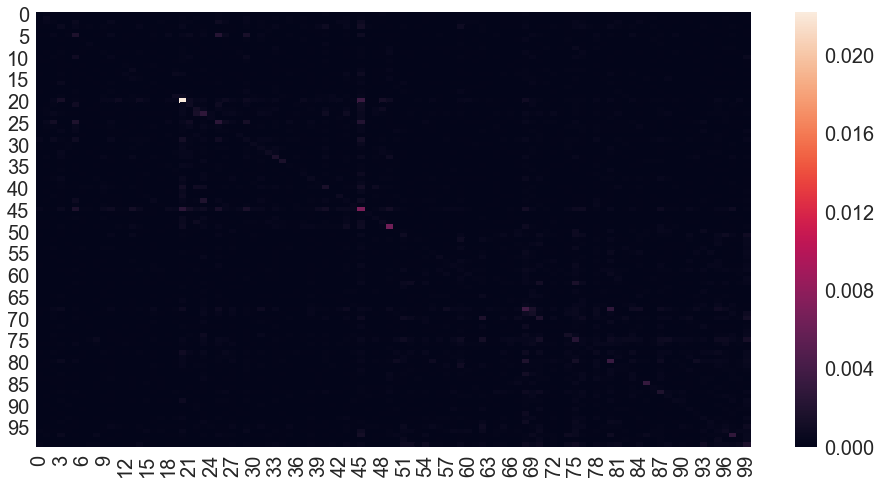

In [254]:
%%time

# km_gold = rbf_kernel(data, gamma=1/100)
km_gold = linear_kernel(data)
out_matrix, bernstein_results = bernstein_sparsification(csr_matrix(km_gold), epsilon, random_seed=0, debug_every=100)

plt.figure(figsize=(16, 8))
sns.heatmap(out_matrix.toarray())
plt.savefig("bernstein-sampling.png", dpi=300)

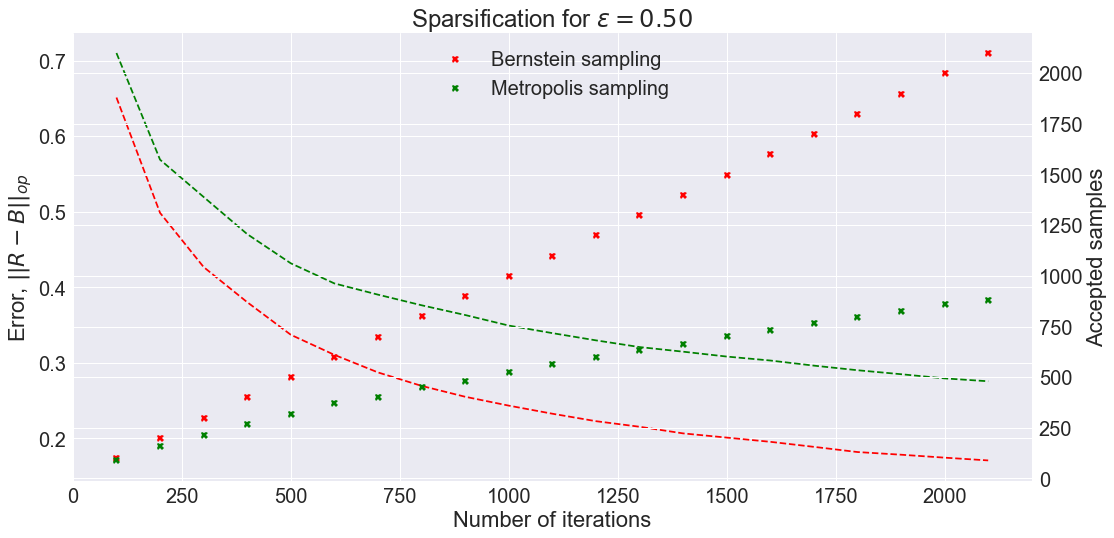

In [191]:
# Diplay all results

xs = np.linspace(0, 100 * (len(bernstein_results[0]) - 1), len(bernstein_results[0])) + 100

fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.plot(xs, bernstein_results[0], 'r--')
ax1.plot(xs, metropolis_results[0], 'g--')
ax1.set_title("Sparsification for $\\varepsilon = %.2f$" % epsilon)
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("Error, $||R-B||_{op}$")

ax2 = ax1.twinx()
ax2.plot(xs, bernstein_results[1], 'rX')
ax2.plot(xs, metropolis_results[1], 'gX')
ax2.set_ylabel("Accepted samples")

fig.tight_layout()
plt.legend(['Bernstein sampling', 'Metropolis sampling'], loc='upper center')
plt.savefig('comparison_%.2f.png' % epsilon, bbox_inches='tight', dpi=300)

In [156]:
for i in range(100):
    for j in range(100):
        if out_matrix[i, j] > 0:
            out_matrix[i, j] *= y_mul_kostyl(i, j)

In [401]:
out_matrix

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 8521 stored elements in Compressed Sparse Row format>

In [161]:
with open("bernstein_km.dump", "wb") as fout:
    pickle.dump(out_matrix, fout)

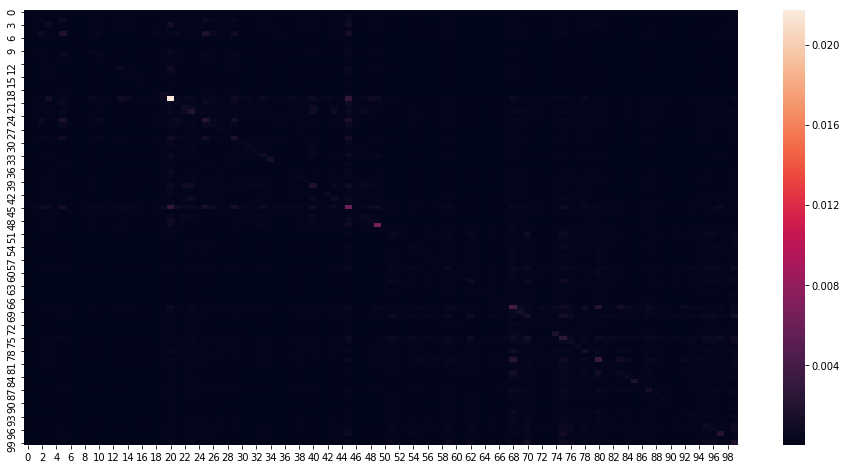

In [402]:
plt.figure(figsize=(16, 8))
sns.heatmap(km_gold/norm)
plt.savefig("original-kernel-matrix.png", dpi=300)

In [185]:
km_gold_kostyl = csr_matrix(km_gold.copy())

for i in range(100):
    for j in range(100):
        if km_gold[i, j] > 0:
            km_gold_kostyl[i, j] *= y_mul_kostyl(i, j) / norm

In [192]:
with open("original_km.dump", "wb") as fout:
    pickle.dump(km_gold_kostyl, fout)

In [196]:
with open("bernstein_km.dump", "rb") as fin:
    kek = pickle.load(fin)

In [194]:
with open("original_km.dump", "rb") as fin:
    kek = pickle.load(fin)

In [197]:
kek

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 8521 stored elements in Compressed Sparse Row format>

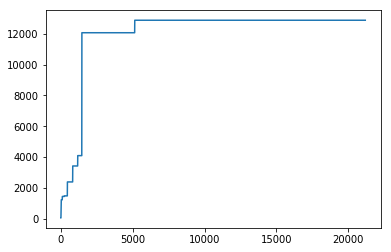

In [172]:
plt.plot(bests)

In [143]:
km_gold.max()

42413.0

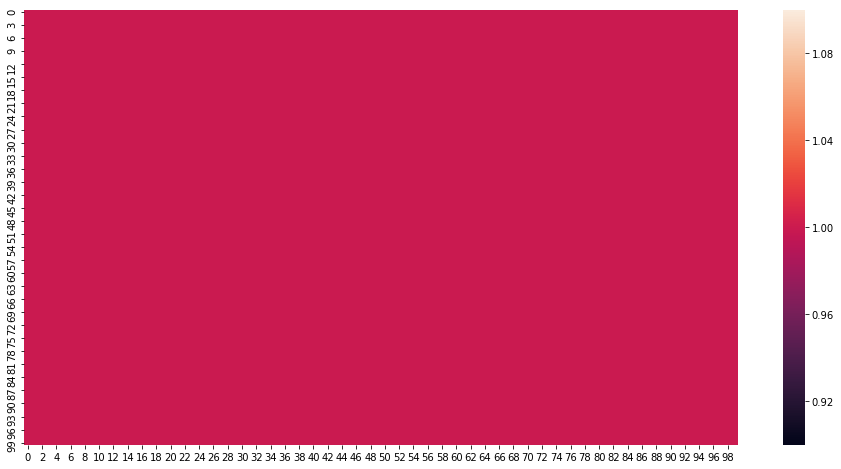

In [126]:
plt.figure(figsize=(16, 8))
sns.heatmap(np.int32((km_gold)>0))

---